In [100]:
import pandas as pd
#None para visualizar todas las columnas, False para la version recortada
pd.set_option("display.max_columns", False)

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
drive_path = '/content/drive/MyDrive/Mineria/'
training_filename = "training_df.csv"
training_df = pd.read_csv(drive_path+training_filename,
                          dtype={"in_reply_to_status_id":str, "in_reply_to_user_id":str, })

In [103]:
print(training_df)

        ans                      created_at  ...              user_id class
0         0  Thu Jan 14 12:20:31 +0000 2021  ...           2798939859     0
1         0  Sat Jan 02 15:40:26 +0000 2021  ...            611616139     0
2         0  Wed Feb 24 22:46:20 +0000 2021  ...            425539845     0
3         0  Fri Feb 19 21:44:40 +0000 2021  ...            950509741     0
4         0  Sun Jan 31 12:37:21 +0000 2021  ...             94587196     0
...     ...                             ...  ...                  ...   ...
130461    0  Sun Jan 31 01:49:58 +0000 2021  ...  1165057182267781120     0
130462    1  Wed Feb 03 00:16:18 +0000 2021  ...  1343995343009099776     1
130463    1  Sun Mar 07 12:16:17 +0000 2021  ...            336674598     1
130464    0  Tue Mar 16 00:47:00 +0000 2021  ...  1311701826341871616     0
130465    0  Sat Mar 20 11:01:01 +0000 2021  ...            574985459     0

[130466 rows x 8 columns]


In [104]:
#reducimos la cantidad de tuits porque la ram no soporta para el entrenamiento
training_array = training_df['full_text'].to_numpy()[:25000]
training_class = training_df['class'].to_numpy()[:25000]

In [105]:
from sklearn.feature_extraction.text import CountVectorizer

coun_vect = CountVectorizer(min_df=2)#,max_df=0.75)
count_matrix = coun_vect.fit_transform(training_array)
count_array = count_matrix.toarray()

vectors_training_df = pd.DataFrame(data=count_array,columns = coun_vect.get_feature_names())
print(vectors_training_df)

#con develop:
#con min_df=2: [16308 rows x 11628 columns]
#sin: [16308 rows x 28478 columns]

       00  000  01  02  023  ...  únicas  único  únicos  úrsula  útil
0       0    0   0   0    0  ...       0      0       0       0     0
1       0    0   0   0    0  ...       0      0       0       0     0
2       0    0   0   0    0  ...       0      0       0       0     0
3       0    0   0   0    0  ...       0      0       0       0     0
4       0    0   0   0    0  ...       0      0       0       0     0
...    ..  ...  ..  ..  ...  ...     ...    ...     ...     ...   ...
24995   0    0   0   0    0  ...       0      0       0       0     0
24996   0    0   0   0    0  ...       0      0       0       0     0
24997   0    0   0   0    0  ...       0      0       0       0     0
24998   0    0   0   0    0  ...       0      0       0       0     0
24999   0    0   0   0    0  ...       0      0       0       0     0

[25000 rows x 15319 columns]


In [ ]:
#https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/Logistic_Regression/LogisticRegression_toy_digits_Codementor.ipynb
#https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()#max_iter=200)

# Entrenamos con los vectores y sus tags
logisticRegr.fit(vectors_training_df, training_class)


In [109]:
develop_filename = "develop_df.csv"
develop_df = pd.read_csv(drive_path+develop_filename, dtype={"in_reply_to_status_id":str, "in_reply_to_user_id":str, })
develop_array = develop_df['full_text'].to_numpy()

#Hay que usar el mismo vocabulario, para que tengan las mismas columnas
coun_vect2 = CountVectorizer(vocabulary=coun_vect.vocabulary_)
count_matrix2 = coun_vect2.fit_transform(develop_array)
count_array2 = count_matrix2.toarray()
vectors_develop_df = pd.DataFrame(data=count_array2,columns = coun_vect2.get_feature_names())

develop_class = develop_df['class'].to_numpy()


In [111]:
#predecir para valores individuales:
#3, 22 y 86 tuits poco argumentativos (0)
#6, 43 tuits con alguna estructura o argumento (1 o 2-3)
#1636 y 6054 171 9054 15444 15706 tuits con la actualizacion de la informacion(4+)
examples_idx = [3, 22, 86, 6, 43, 171, 1634, 6052, 9054, 15444, 15706]
examples_text = []
examples_real_tag = []
examples_predicted_tag = []
for i in examples_idx:
  examples_text.append(develop_array[i])
  examples_real_tag.append(develop_class[i])
  examples_predicted_tag.append(logisticRegr.predict(vectors_develop_df[i:i+1])[0])

In [121]:
print(examples_text)
print(examples_real_tag)
print(examples_predicted_tag)

j = 0
for j in range(len(examples_real_tag)):
  print("+"*80)
  print(f'Ejemplo {j}:\n Tag real:     {examples_real_tag[j]}\n Tag obtenida: {examples_predicted_tag[j]}\n Texto del tuit: \n{examples_text[j]}')

['Que asco.', 'Un sujeto nefasto.', 'Claro!!!! No es tan difícil de entender!!!', 'No. No es así. Hay más datos publicados de algunas vacunas que de otras. Hay datos mejor medidos para algunas vacunas que para otras. Hay evaluaciones más rigurosas sobre algunas vacunas que sobre otras. No da todo igual. Decir que es todo igual es negar la realidad.', 'No seas exagerado, eso es signo de desesperación\nLos turnos se estaban dando para esta semana\nAl final, para cuando conseguiste?', 'Situación #COVID19 en Argentina\n\nConfirmados: 9.471 | Total:\xa01.905.524 casos          \n\nFallecidos: 166 | Total:\xa047.601            \n\nOcupación camas UTI: 3.607\n\nPorcentaje ocupación total camas UTI adulto:\n \n- Nación: 55,3% \n- AMBA: 62%\n\nReporte completo: https://t.co/HUbXwfQmu3 https://t.co/BmJVM2M3Rj', 'Situación #COVID19 en Argentina\n\nConfirmados: 8.704 | Total: \xa01.730.921    \n\nFallecidos: 160 | Total: \xa044.654   \n\nOcupación camas UTI: \xa03.606\n\nPorcentaje ocupación total

In [113]:
# Conseguir el porcentaje de acierto del modelo
score = logisticRegr.score(vectors_develop_df, develop_class)
print(score)

0.6847559480009812


In [114]:
import numpy as np 
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

In [115]:
predictions = logisticRegr.predict(vectors_develop_df)
cm = metrics.confusion_matrix(develop_class, predictions)

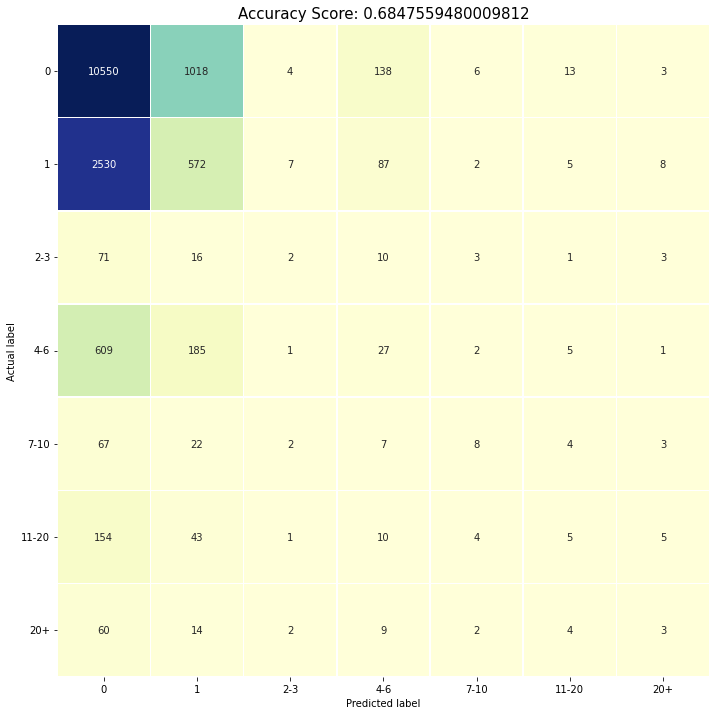

In [116]:
# Visualizar que label toco y cual deberia haber tocado 
clases = ["0","1","2-3","4-6","7-10","11-20","20+"]
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, robust=True, cmap = 'YlGnBu', cbar=False);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.yticks(plt.yticks()[0], labels=clases, rotation=0)
plt.xticks(plt.xticks()[0], labels=clases)
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.savefig(drive_path+'1er_test_BOW.png')
#plt.show();